<h1>MLPNN model on GAMEEMO raw dataset, 7 secs grouping</h1>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #only show errors (hide INFO and WARNING)

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

random.seed(1234)   
np.random.seed(1234)


<h3>Helper functions to plot loss/accuracy, and build/train/test models.</h3>

In [2]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [18]:
def build_model(sample_size, num_of_features, dense_layers_unit_array=[], learningRate=0.001,
                activation="relu", isBatchNormalized=False, dropOutRate=0,
                startWithBatchNormalized=False,optimizer="Adam",
                conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[]
               ):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of GPU/CPU: {}'.format(strategy.num_replicas_in_sync))
    
    print("num_of_dense_layers:",len(dense_layers_unit_array))
    
    for i, dense_layer_unit in enumerate(dense_layers_unit_array):       
        print("dense_layer["+str(i)+"]; unit:"+str(dense_layer_unit))      
        
        
    print("num_of_conv_layers:",len(conv_layers_filters_array))    
    for i, conv_layer_filters in enumerate(conv_layers_filters_array):       
        print("conv_layer_filters["+str(i)+"]; unit:"+str(conv_layer_filters))  
        print("conv_kernel["+str(i)+"]; unit:"+str(conv_kernel_size_array[i]))
        print("conv_strides["+str(i)+"]; unit:"+str(conv_strides_array[i]))
       
    print("learningRate:",learningRate)
    print("isBatchNormalized:",isBatchNormalized,"; dropOutRate:",dropOutRate)
    
    startWithBatchNormalized = startWithBatchNormalized or optimizer == "SGD"
    print("startWithBatchNormalized:",startWithBatchNormalized)
    print("optimizer:",optimizer,"; activation:",activation)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential() 
        
        if startWithBatchNormalized:
            model.add(BatchNormalization())
        
        # Add Conv layers
        for i, conv_layer_filters in enumerate(conv_layers_filters_array):    
            model.add(tf.keras.layers.Conv1D(
            filters=conv_layer_filters,                
            kernel_size=conv_kernel_size_array[i],
            strides=conv_strides_array[i],
            padding='same',
            data_format='channels_last',
            name='conv_'+str(i),
            activation='relu'))
        
            model.add(tf.keras.layers.MaxPool1D(
                pool_size=2,
                name='pool_'+str(i))) 

        if len(conv_layers_filters_array) > 0:    
            model.add(Flatten()) 
        
        # Add Dense layers
        for i, dense_layer_unit in enumerate(dense_layers_unit_array):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_unit,
                name='fc_'+str(i), 
                activation=activation))
            if isBatchNormalized:
                model.add(BatchNormalization())
            if dropOutRate > 0:
                model.add(Dropout(dropOutRate))
                
        if len(conv_layers_filters_array) == 0 and len(dense_layers_unit_array) > 0:    
            model.add(Flatten()) 
                
        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, sample_size, num_of_features))

        if optimizer=="Adam":
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        elif optimizer=="SGD":
            opt = keras.optimizers.SGD(learning_rate=learningRate)
        else:
            opt = keras.optimizers.Adam(learning_rate=learningRate)    
        

        model.compile(optimizer=opt,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])    
    
    return model
    

In [4]:
def train_and_test_model(sample_size, num_of_features,
                         train_dataset, validate_dataset, x_train,
                         save_to, epoch = 2,
                         dense_layers_unit_array=[],
                         patience=10, epoch_denominator=10.,
                         isConstantLearningRate=False, learningRate=0.001,
                         activation="relu", isBatchNormalized=False,dropOutRate=0,
                         startWithBatchNormalized=False,optimizer="Adam",
                         conv_layers_filters_array=[],conv_kernel_size_array=[],conv_strides_array=[]
                        ):
    
    print("epoch:",epoch, "; epoch_denominator:",epoch_denominator) 
    print("patience:",patience,"; isConstantLearningRate:", isConstantLearningRate) 
    
    model = build_model(sample_size, num_of_features,
                        dense_layers_unit_array=dense_layers_unit_array, learningRate=learningRate,
                        activation=activation, isBatchNormalized=isBatchNormalized, dropOutRate=dropOutRate,
                        startWithBatchNormalized=startWithBatchNormalized,optimizer=optimizer,
                        conv_layers_filters_array=conv_layers_filters_array,
                        conv_kernel_size_array=conv_kernel_size_array,
                        conv_strides_array=conv_strides_array
                       )

    model.summary()
    tf.keras.utils.plot_model(model)  
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    if isConstantLearningRate:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
    else:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))

    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])

    history_data = pd.DataFrame(history.history)
    plot_loss_history(history_data)
    plot_accuracy_history(history_data)

    # test model
    test_results = model.evaluate(test_dataset)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    # show classification report
    y_predict = np.array(model.predict(test_dataset))
    y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
    print(classification_report(y_test, y_predict))
    
    print("Confusion matrix")
    print(confusion_matrix(y_test.values.argmax(axis=1), np.argmax(y_predict, axis=1)))


In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

path="dataset_gameemo/original_data_with_timestamps"
dirs = os.listdir(path)

X_7_sec = []
y = []

num_of_features = 14
num_of_records_per_experiment=37632
num_of_samples = 42
sample_size=int(num_of_records_per_experiment/num_of_samples)

for file in dirs:
    df = pd.read_csv('dataset_gameemo/original_data_with_timestamps/' + file)
    df.drop(columns='timestamps', inplace=True)
    list_of_arrays = np.array_split(df[:num_of_records_per_experiment],num_of_samples)
    for array in list_of_arrays:
        X_7_sec.append(array)
        category = str(file)[4]
        y.append(label_map[int(category)])
X_7_sec = np.array(X_7_sec)
# y = np.array([int(cat)-1 for cat in y])

X_train, X_validate, y_train, y_validate = train_test_split(X_7_sec, y, train_size=0.6, random_state=0)
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=0)


y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)

print("y_train.shape:", y_train.shape)
print("y_validate.shape:", y_validate.shape)
print("y_test.shape:", y_test.shape)

print("y_train:")
print(y_train[:5])

#######
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

batch_size = 30
train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


y_train.shape: (2822, 4)
y_validate.shape: (941, 4)
y_test.shape: (941, 4)
y_train:
   HA_NV  HA_PV  LA_NV  LA_PV
0      0      0      0      1
1      1      0      0      0
2      0      1      0      0
3      1      0      0      0
4      0      0      1      0


<h3>Manual runs to get a feel of the hyperparameters</h3>

Try different combinations of startWithBatchNormalized and isBatchNormalized.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 0
learningRate: 0.1
isBatchNormalized: True ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 896, 512)          7680      
_________________________________________________________________
batch_normalization (BatchNo (None, 896, 512)          2048      
_________________________________________________________________
dropout (Dropout)            (None, 896, 512)          0         
_________________________________________________________________
fla

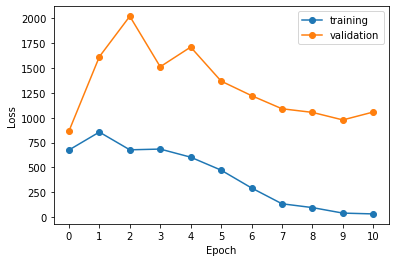

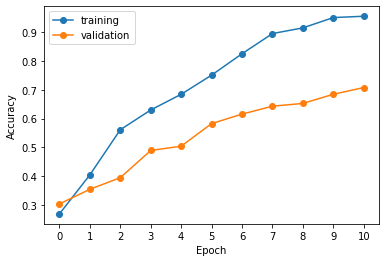

32/32 [==============================] - 0s 6ms/step - loss: 1108.6051 - accuracy: 0.6684 - precision: 0.6684 - recall: 0.6684

Test Acc. 66.84%
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       236
           1       0.65      0.73      0.68       240
           2       0.72      0.65      0.68       239
           3       0.66      0.62      0.64       226

   micro avg       0.67      0.67      0.67       941
   macro avg       0.67      0.67      0.67       941
weighted avg       0.67      0.67      0.67       941
 samples avg       0.67      0.67      0.67       941

Confusion matrix
[[158  38  11  29]
 [ 27 175  19  19]
 [ 36  24 155  24]
 [ 22  34  29 141]]


In [19]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     isBatchNormalized=True
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 0
learningRate: 0.1
isBatchNormalized: True ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 896, 14)           56        
_________________________________________________________________
fc_0 (Dense)                 (None, 896, 512)          7680      
_________________________________________________________________
batch_normalization_1 (Batch (None, 896, 512)          2048      
_________________________________________________________________
drop

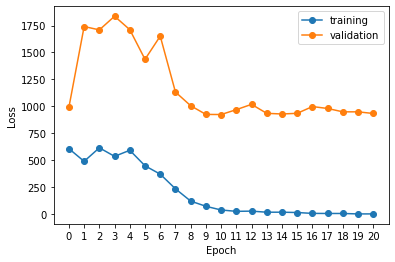

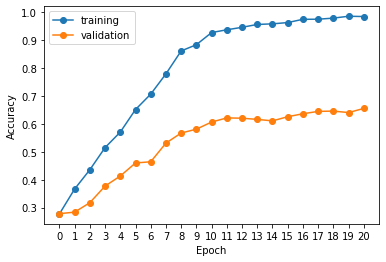

32/32 [==============================] - 0s 7ms/step - loss: 956.0729 - accuracy: 0.6408 - precision: 0.6408 - recall: 0.6408

Test Acc. 64.08%
              precision    recall  f1-score   support

           0       0.58      0.63      0.60       236
           1       0.66      0.68      0.67       240
           2       0.67      0.62      0.64       239
           3       0.65      0.63      0.64       226

   micro avg       0.64      0.64      0.64       941
   macro avg       0.64      0.64      0.64       941
weighted avg       0.64      0.64      0.64       941
 samples avg       0.64      0.64      0.64       941

Confusion matrix
[[148  35  27  26]
 [ 39 164  17  20]
 [ 35  26 148  30]
 [ 32  22  29 143]]


In [20]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     isBatchNormalized=True
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 0
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 896, 512)          7680      
_________________________________________________________________
dropout (Dropout)            (None, 896, 512)          0         
_________________________________________________________________
flatten (Flatten)            (None, 458752)            0         
_________________________________________________________________
de

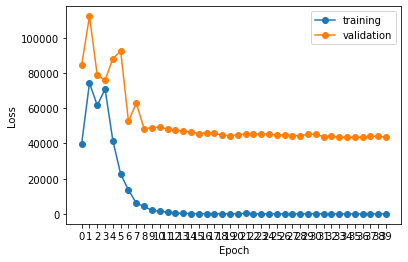

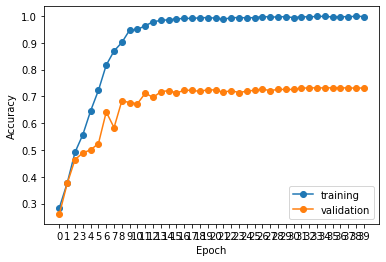

32/32 [==============================] - 0s 6ms/step - loss: 39947.0078 - accuracy: 0.7258 - precision: 0.7258 - recall: 0.7258

Test Acc. 72.58%
              precision    recall  f1-score   support

           0       0.73      0.70      0.72       236
           1       0.79      0.75      0.76       240
           2       0.72      0.75      0.73       239
           3       0.67      0.70      0.69       226

   micro avg       0.73      0.73      0.73       941
   macro avg       0.73      0.73      0.73       941
weighted avg       0.73      0.73      0.73       941
 samples avg       0.73      0.73      0.73       941

Confusion matrix
[[166  24  18  28]
 [ 32 179  14  15]
 [ 13  12 180  34]
 [ 16  13  39 158]]


In [21]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     isBatchNormalized=False
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 0
learningRate: 0.1
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 896, 14)           56        
_________________________________________________________________
fc_0 (Dense)                 (None, 896, 512)          7680      
_________________________________________________________________
dropout (Dropout)            (None, 896, 512)          0         
_________________________________________________________________
fla

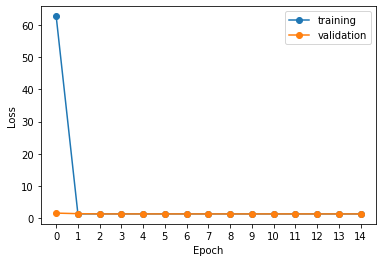

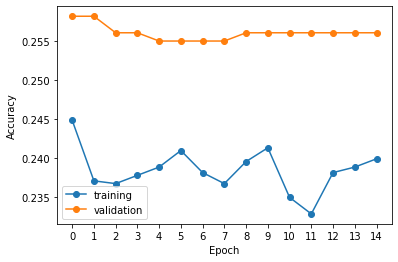

32/32 [==============================] - 0s 6ms/step - loss: 1.3864 - accuracy: 0.2561 - precision: 0.3333 - recall: 0.0011  

Test Acc. 25.61%
              precision    recall  f1-score   support

           0       0.33      0.00      0.01       236
           1       1.00      0.00      0.01       240
           2       0.26      1.00      0.41       239
           3       0.00      0.00      0.00       226

   micro avg       0.26      0.26      0.26       941
   macro avg       0.40      0.25      0.11       941
weighted avg       0.40      0.26      0.11       941
 samples avg       0.26      0.26      0.26       941

Confusion matrix
[[  1   0 235   0]
 [  1   1 238   0]
 [  0   0 239   0]
 [  1   0 225   0]]


/home/bizon/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.1,
                     startWithBatchNormalized=True, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     isBatchNormalized=False
                    )

Try lower learning rate to reduce loss. Results: test accuracy seems to max at 70%. loss improved.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_conv_layers: 0
learningRate: 0.001
isBatchNormalized: True ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 896, 512)          7680      
_________________________________________________________________
batch_normalization (BatchNo (None, 896, 512)          2048      
_________________________________________________________________
dropout (Dropout)            (None, 896, 512)          0         
_________________________________________________________________
f

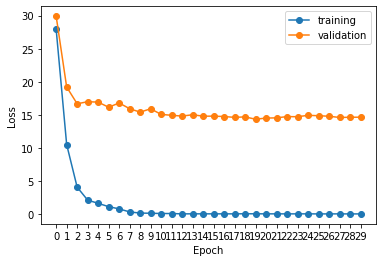

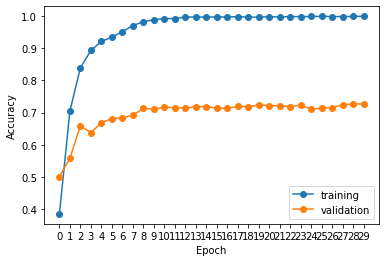

32/32 [==============================] - 0s 6ms/step - loss: 16.3582 - accuracy: 0.7003 - precision: 0.7003 - recall: 0.7003

Test Acc. 70.03%
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       236
           1       0.72      0.74      0.73       240
           2       0.74      0.69      0.72       239
           3       0.65      0.70      0.67       226

   micro avg       0.70      0.70      0.70       941
   macro avg       0.70      0.70      0.70       941
weighted avg       0.70      0.70      0.70       941
 samples avg       0.70      0.70      0.70       941

Confusion matrix
[[157  28  16  35]
 [ 27 178  13  22]
 [ 28  17 166  28]
 [ 17  23  28 158]]


In [23]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     isBatchNormalized=True
                    )

Try 2 dense layers. Results: improved to 72.69%. loss also improved.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:512
dense_layer[1]; unit:256
num_of_conv_layers: 0
learningRate: 0.001
isBatchNormalized: True ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 896, 512)          7680      
_________________________________________________________________
batch_normalization (BatchNo (None, 896, 512)          2048      
_________________________________________________________________
dropout (Dropout)            (None, 896, 512)          0         
__________________________________________

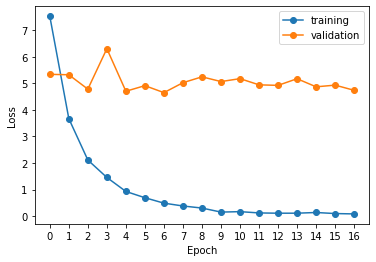

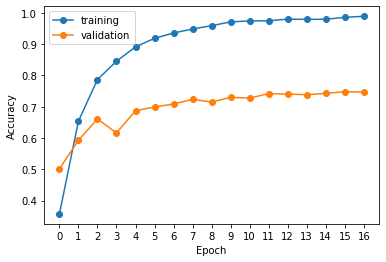

32/32 [==============================] - 0s 7ms/step - loss: 5.1404 - accuracy: 0.7269 - precision: 0.7274 - recall: 0.7258

Test Acc. 72.69%
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       236
           1       0.78      0.74      0.76       240
           2       0.72      0.75      0.73       239
           3       0.66      0.72      0.69       226

   micro avg       0.73      0.73      0.73       941
   macro avg       0.73      0.73      0.73       941
weighted avg       0.73      0.73      0.73       941
 samples avg       0.73      0.73      0.73       941

Confusion matrix
[[164  19  24  29]
 [ 27 178  13  22]
 [ 17  11 179  32]
 [  9  20  34 163]]


In [24]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,256], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     isBatchNormalized=True
                    )

Try 3 dense layers. Results: loss improves, but accuracy drops.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 3
dense_layer[0]; unit:512
dense_layer[1]; unit:256
dense_layer[2]; unit:128
num_of_conv_layers: 0
learningRate: 0.001
isBatchNormalized: True ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 896, 512)          7680      
_________________________________________________________________
batch_normalization (BatchNo (None, 896, 512)          2048      
_________________________________________________________________
dropout (Dropout)            (None, 896, 512)          0         
_________________

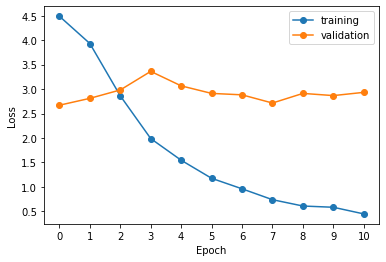

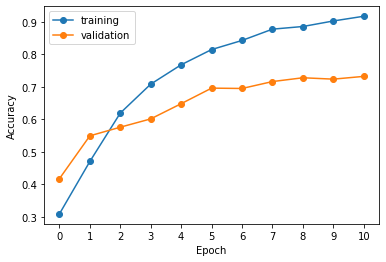

32/32 [==============================] - 0s 8ms/step - loss: 3.0374 - accuracy: 0.7035 - precision: 0.7082 - recall: 0.7014

Test Acc. 70.35%
              precision    recall  f1-score   support

           0       0.72      0.61      0.67       236
           1       0.72      0.80      0.76       240
           2       0.64      0.75      0.69       239
           3       0.75      0.64      0.69       226

   micro avg       0.70      0.70      0.70       941
   macro avg       0.71      0.70      0.70       941
weighted avg       0.71      0.70      0.70       941
 samples avg       0.70      0.70      0.70       941

Confusion matrix
[[145  35  41  15]
 [ 20 193  17  10]
 [ 16  20 180  23]
 [ 19  20  43 144]]


In [25]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,256,128], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     isBatchNormalized=True
                    )

Try SGD optimizer. Results: same as Adam.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:512
dense_layer[1]; unit:256
num_of_conv_layers: 0
learningRate: 0.001
isBatchNormalized: True ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 896, 14)           56        
_________________________________________________________________
fc_0 (Dense)                 (None, 896, 512)          7680      
_________________________________________________________________
batch_normalization_1 (Batch (None, 896, 512)          2048      
____________________________________________

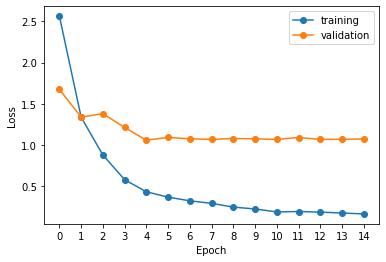

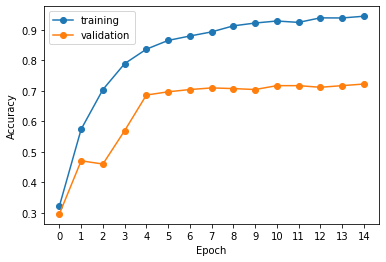

32/32 [==============================] - 0s 7ms/step - loss: 1.0650 - accuracy: 0.7226 - precision: 0.7658 - recall: 0.6950

Test Acc. 72.26%
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       236
           1       0.77      0.74      0.75       240
           2       0.73      0.69      0.71       239
           3       0.68      0.76      0.71       226

   micro avg       0.72      0.72      0.72       941
   macro avg       0.72      0.72      0.72       941
weighted avg       0.72      0.72      0.72       941
 samples avg       0.72      0.72      0.72       941

Confusion matrix
[[166  25  20  25]
 [ 23 177  15  25]
 [ 26  15 166  32]
 [ 14  14  27 171]]


In [26]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,256], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     isBatchNormalized=True
                    )

Try tanh activation. Results: accuracy drops.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:512
dense_layer[1]; unit:256
num_of_conv_layers: 0
learningRate: 0.001
isBatchNormalized: True ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: tanh
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 896, 512)          7680      
_________________________________________________________________
batch_normalization (BatchNo (None, 896, 512)          2048      
_________________________________________________________________
dropout (Dropout)            (None, 896, 512)          0         
__________________________________________

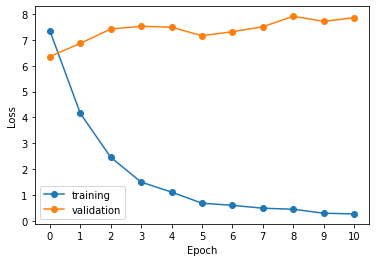

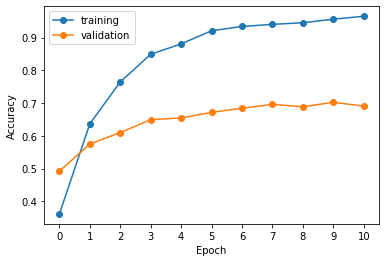

32/32 [==============================] - 0s 8ms/step - loss: 8.2857 - accuracy: 0.6908 - precision: 0.6915 - recall: 0.6908

Test Acc. 69.08%
              precision    recall  f1-score   support

           0       0.68      0.65      0.67       236
           1       0.67      0.73      0.70       240
           2       0.74      0.70      0.72       239
           3       0.68      0.67      0.68       226

   micro avg       0.69      0.69      0.69       941
   macro avg       0.69      0.69      0.69       941
weighted avg       0.69      0.69      0.69       941
 samples avg       0.69      0.69      0.69       941

Confusion matrix
[[154  32  23  27]
 [ 26 176  18  20]
 [ 26  20 168  25]
 [ 21  34  19 152]]


In [27]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,256], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="tanh",
                     isBatchNormalized=True
                    )

Try less dense layers units. Results: accuracy slightly drops.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:256
dense_layer[1]; unit:128
num_of_conv_layers: 0
learningRate: 0.001
isBatchNormalized: True ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 896, 256)          3840      
_________________________________________________________________
batch_normalization (BatchNo (None, 896, 256)          1024      
_________________________________________________________________
dropout (Dropout)            (None, 896, 256)          0         
__________________________________________

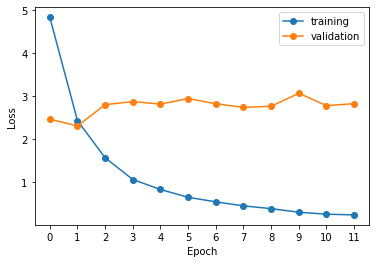

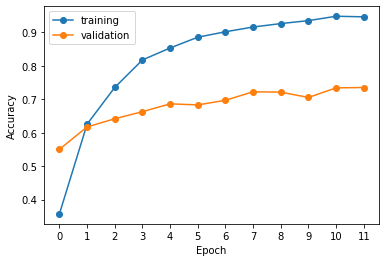

32/32 [==============================] - 0s 7ms/step - loss: 2.8469 - accuracy: 0.7078 - precision: 0.7109 - recall: 0.7056

Test Acc. 70.78%
              precision    recall  f1-score   support

           0       0.72      0.65      0.68       236
           1       0.77      0.71      0.74       240
           2       0.70      0.73      0.71       239
           3       0.65      0.75      0.70       226

   micro avg       0.71      0.71      0.71       941
   macro avg       0.71      0.71      0.71       941
weighted avg       0.71      0.71      0.71       941
 samples avg       0.71      0.71      0.71       941

Confusion matrix
[[153  25  26  32]
 [ 28 170  16  26]
 [ 22  11 174  32]
 [  9  15  33 169]]


In [28]:
train_and_test_model(sample_size, num_of_features, 
                     train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[256,128], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     isBatchNormalized=True
                    )

<h3>Conclusion</h3>

Manual tuning on MLPNN: 72.69% accuracy </br>

num_of_dense_layers: 2 </br>
dense_layer[0]; unit:512 </br>
dense_layer[1]; unit:256 </br>
num_of_conv_layers: 0 </br>
learningRate: 0.001 </br>
isBatchNormalized: True </br>
dropOutRate: 0.5 </br>
startWithBatchNormalized: False </br>
optimizer: Adam </br>
activation: relu </br>
